In [1]:
#download dataset from https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
!pip install kaggle
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 89% 73.0M/82.0M [00:00<00:00, 80.0MB/s]
100% 82.0M/82.0M [00:01<00:00, 83.1MB/s]


In [2]:
#unzip file that has been downloaded
import os
import zipfile

# List of zip file paths
zip_files = ['/content/garbage-classification.zip']

extract_to = '/content'

# Loop through each zip file and extract
for zip_file in zip_files:
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [5]:
#define dataset directory and get list of labels
import os
base_dir = '/content/Garbage classification/Garbage classification'
class_labels = os.listdir(base_dir)
class_labels.sort()
print(class_labels)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
for label in class_labels:
  path = os.path.join(base_dir,label)
  size = len(os.listdir(path))
  print(f"Target Label : {label}, number of sample in data : {size}")

Target Label : cardboard, number of sample in data : 403
Target Label : glass, number of sample in data : 501
Target Label : metal, number of sample in data : 410
Target Label : paper, number of sample in data : 594
Target Label : plastic, number of sample in data : 482
Target Label : trash, number of sample in data : 137


In [7]:
#apply random oversampling to achieve a balanced distribution of classes
import os
import shutil
import numpy as np
import uuid
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Function to apply random oversampling
base_dir = '/content/Garbage classification/Garbage classification'
oversamp_dir = '/content/oversamp_data'

# Function to copy data
def copy_data(base_dir, temp_dir):
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    shutil.copytree(base_dir, temp_dir)
    print(f"Copied data from {base_dir} to {temp_dir}")

def apply_oversampling(base_dir, oversamp_dir):
    classes = [cls for cls in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, cls))]
    images_paths = []
    labels = []

    # Collect all image paths and their corresponding labels
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        print(f"Processing directory: {cls_path}")
        images = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        print(f"Found {len(images)} images in {cls_path}")

        images_paths.extend(images)
        labels.extend([cls] * len(images))

    print(f"Collected {len(images_paths)} images from {len(classes)} classes.")
    if len(images_paths) == 0:
        print("No images found. Please check the directory structure and paths.")
        return

    # Apply random oversampling
    ros = RandomOverSampler()
    images_paths_resampled, labels_resampled = ros.fit_resample(np.array(images_paths).reshape(-1, 1), labels)
    images_paths_resampled = images_paths_resampled.flatten()

    print("Oversampling completed.")
    print(f"Original counts: {Counter(labels)}")
    print(f"Resampled counts: {Counter(labels_resampled)}")

    # Create the oversampled dataset directory structure
    for cls in classes:
        cls_path = os.path.join(oversamp_dir, cls)
        os.makedirs(cls_path, exist_ok=True)

    for img_path, label in zip(images_paths_resampled, labels_resampled):
        cls_path = os.path.join(oversamp_dir, label)
        os.makedirs(cls_path, exist_ok=True)  # Ensure the class directory exists
        # Generate a unique file name
        file_name, file_extension = os.path.splitext(os.path.basename(img_path))
        unique_file_name = f"{file_name}_{uuid.uuid4().hex}{file_extension}"
        dest_path = os.path.join(cls_path, unique_file_name)
        shutil.copy(img_path, dest_path)

    print("Data saved to oversamp_dir.")

# Temporary directory to copy original data for oversampling
temp_dir = '/content/temp_data'
copy_data(base_dir, temp_dir)

# Apply oversampling to the copied data
apply_oversampling(temp_dir, oversamp_dir)

# Clean up the temporary directory
shutil.rmtree(temp_dir)

Copied data from /content/Garbage classification/Garbage classification to /content/temp_data
Processing directory: /content/temp_data/metal
Found 410 images in /content/temp_data/metal
Processing directory: /content/temp_data/paper
Found 594 images in /content/temp_data/paper
Processing directory: /content/temp_data/glass
Found 501 images in /content/temp_data/glass
Processing directory: /content/temp_data/trash
Found 137 images in /content/temp_data/trash
Processing directory: /content/temp_data/cardboard
Found 403 images in /content/temp_data/cardboard
Processing directory: /content/temp_data/plastic
Found 482 images in /content/temp_data/plastic
Collected 2527 images from 6 classes.
Oversampling completed.
Original counts: Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})
Resampled counts: Counter({'metal': 594, 'paper': 594, 'glass': 594, 'trash': 594, 'cardboard': 594, 'plastic': 594})
Data saved to oversamp_dir.


In [1]:
#check dataset that has been oversampled
import os
base_dir = '/content/oversamp_data'
class_labels = os.listdir(base_dir)
class_labels.sort()
print(class_labels)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [2]:
for label in class_labels:
  path = os.path.join(base_dir,label)
  size = len(os.listdir(path))
  print(f"Target Label : {label}, number of sample in data : {size}")

Target Label : cardboard, number of sample in data : 594
Target Label : glass, number of sample in data : 594
Target Label : metal, number of sample in data : 594
Target Label : paper, number of sample in data : 594
Target Label : plastic, number of sample in data : 594
Target Label : trash, number of sample in data : 594


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
#create tensorflow dataset for data preprocessing
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3564 files belonging to 6 classes.


In [6]:
class_names = datasets.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [7]:
#define function to split data to train , valid and test dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(datasets)

In [9]:
#optimize the training , valid , and test dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
#create preprocessing pipeline using tf.keras.sequential
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [11]:
# Create Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

In [12]:
#apply data augmentation to training dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

In [14]:
# Load the ResNet50 model with pre-trained weights from ImageNet
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False # Set the model's layers to non-trainable to prevent updating during training


94765736/94765736 [==============================] - 0s 0us/step


In [15]:
#define model architecture
model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#Define early stopping callback
early_stopping = EarlyStopping(
     monitor='val_loss',
     patience=5,
     restore_best_weights=True
 )

In [17]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/100
89/89 [==============================] - 60s 505ms/step - loss: 1.8633 - accuracy: 0.2327 - val_loss: 1.7491 - val_accuracy: 0.2557
Epoch 2/100
89/89 [==============================] - 35s 396ms/step - loss: 1.7329 - accuracy: 0.2737 - val_loss: 1.6984 - val_accuracy: 0.3494
Epoch 3/100
89/89 [==============================] - 31s 352ms/step - loss: 1.6760 - accuracy: 0.3013 - val_loss: 1.6298 - val_accuracy: 0.3324
Epoch 4/100
89/89 [==============================] - 31s 343ms/step - loss: 1.6516 - accuracy: 0.3045 - val_loss: 1.7015 - val_accuracy: 0.2244
Epoch 5/100
89/89 [==============================] - 30s 338ms/step - loss: 1.6178 - accuracy: 0.3359 - val_loss: 1.5541 - val_accuracy: 0.4205
Epoch 6/100
89/89 [==============================] - 37s 414ms/step - loss: 1.6030 - accuracy: 0.3384 - val_loss: 1.6231 - val_accuracy: 0.3324
Epoch 7/100
89/89 [==============================] - 30s 336ms/step - loss: 1.6251 - accuracy: 0.3243 - val_loss: 1.5829 - val_accuracy:

In [18]:
scores = model.evaluate(test_ds)
scores

12/12 [==============================] - 11s 114ms/step - loss: 1.5518 - accuracy: 0.3654


[1.5518410205841064, 0.36538460850715637]

In [21]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [22]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#Define early stopping callback
early_stopping = EarlyStopping(
     monitor='val_loss',
     patience=5,
     restore_best_weights=True
 )

In [24]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/100
89/89 [==============================] - 54s 431ms/step - loss: 0.9522 - accuracy: 0.6761 - val_loss: 0.4913 - val_accuracy: 0.8267
Epoch 2/100
89/89 [==============================] - 28s 315ms/step - loss: 0.5323 - accuracy: 0.8179 - val_loss: 0.4004 - val_accuracy: 0.8523
Epoch 3/100
89/89 [==============================] - 28s 318ms/step - loss: 0.4760 - accuracy: 0.8310 - val_loss: 0.4231 - val_accuracy: 0.8523
Epoch 4/100
89/89 [==============================] - 28s 316ms/step - loss: 0.4181 - accuracy: 0.8511 - val_loss: 0.4140 - val_accuracy: 0.8523
Epoch 5/100
89/89 [==============================] - 28s 317ms/step - loss: 0.3874 - accuracy: 0.8624 - val_loss: 0.4045 - val_accuracy: 0.8551
Epoch 6/100
89/89 [==============================] - 28s 316ms/step - loss: 0.3562 - accuracy: 0.8755 - val_loss: 0.3594 - val_accuracy: 0.8864
Epoch 7/100
89/89 [==============================] - 28s 318ms/step - loss: 0.3348 - accuracy: 0.8847 - val_loss: 0.2777 - val_accuracy:

In [25]:
scores = model.evaluate(test_ds)
scores

12/12 [==============================] - 7s 88ms/step - loss: 0.1453 - accuracy: 0.9670


[0.14528681337833405, 0.9670329689979553]

In [ ]:
from tensorflow.keras.applications import DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

In [ ]:


model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 19308614 (73.66 MB)
Trainable params: 986630 (3.76 MB)
Non-trainable params: 18321984 (69.89 MB)
_________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#Define early stopping callback
early_stopping = EarlyStopping(
     monitor='val_loss',
     patience=5,
     restore_best_weights=True
 )

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/100
89/89 [==============================] - 74s 550ms/step - loss: 0.7472 - accuracy: 0.7291 - val_loss: 0.3835 - val_accuracy: 0.8750
Epoch 2/100
89/89 [==============================] - 37s 419ms/step - loss: 0.4028 - accuracy: 0.8628 - val_loss: 0.3047 - val_accuracy: 0.9091
Epoch 3/100
89/89 [==============================] - 35s 392ms/step - loss: 0.3243 - accuracy: 0.8830 - val_loss: 0.2977 - val_accuracy: 0.8977
Epoch 4/100
89/89 [==============================] - 35s 389ms/step - loss: 0.2533 - accuracy: 0.9074 - val_loss: 0.2595 - val_accuracy: 0.9006
Epoch 5/100
89/89 [==============================] - 35s 395ms/step - loss: 0.2271 - accuracy: 0.9151 - val_loss: 0.2273 - val_accuracy: 0.9233
Epoch 6/100
89/89 [==============================] - 35s 400ms/step - loss: 0.1899 - accuracy: 0.9346 - val_loss: 0.1968 - val_accuracy: 0.9261
Epoch 7/100
89/89 [==============================] - 35s 390ms/step - loss: 0.1669 - accuracy: 0.9406 - val_loss: 0.1609 - val_accuracy:

In [ ]:
scores = model.evaluate(test_ds)
scores

12/12 [==============================] - 8s 164ms/step - loss: 0.0662 - accuracy: 0.9753


[0.06622779369354248, 0.9752747416496277]

# Model Selection
Based on our comparison of the trained models ResNet50, InceptionV3, and DenseNet201.We concluded that DenseNet201 achieved the highest accuracy. Therefore, we have chosen DenseNet201 as our pretrained model.

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 89}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

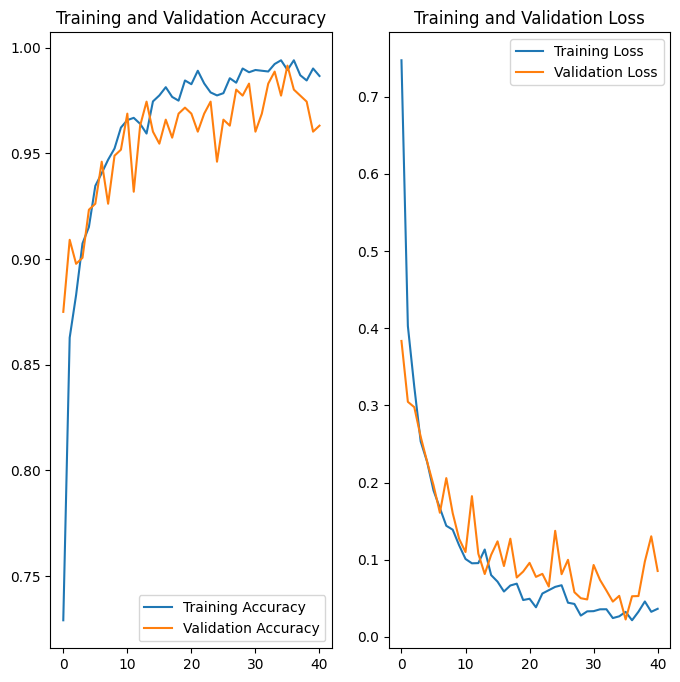

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(41), acc, label='Training Accuracy')
plt.plot(range(41), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(41), loss, label='Training Loss')
plt.plot(range(41), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


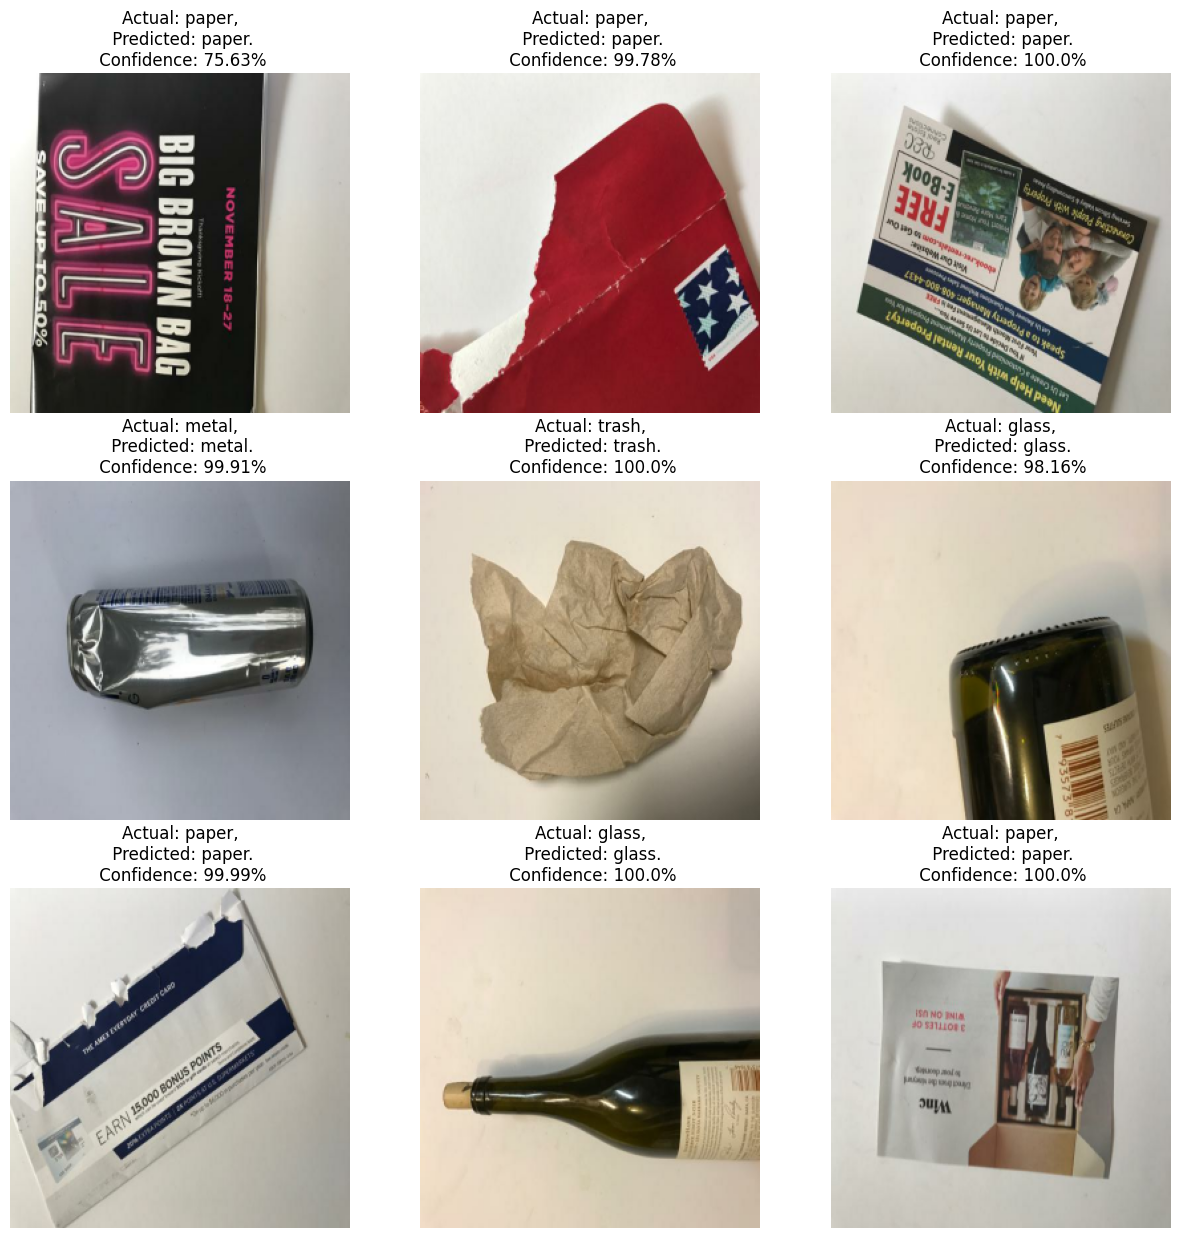

In [ ]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
#export the model to the specified directory
import os
os.makedirs("models")
model_version = [int(i) for i in os.listdir("models") if i.isdigit()]
model.export(f"models/{model_version}")

Saved artifact at 'models/[]'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_2')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133817360057264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087107920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087563856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087558048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133820124047216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087562096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087567200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087573008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087560336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087571776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133817087564032: TensorSpe

In [ ]:
#convert the model to  tflite format
converter = tf.lite.TFLiteConverter.from_saved_model("models/[]")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
#test the tflite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
count = 0
for image, label in test_ds.take(5):
    print(label)

print(count)

tf.Tensor([1 1 1 5 3 1 0 0 5 0 5 1 1 3 0 3 1 4 3 2 1 3 1 2 5 0 4 3 0 2 0 5], shape=(32,), dtype=int32)
tf.Tensor([3 3 3 2 5 1 3 1 3 2 4 5 3 5 2 1 4 0 2 2 5 3 3 0 3 3 3 4 2 4 5 4], shape=(32,), dtype=int32)
tf.Tensor([5 1 4 5 1 2 3 1 5 5 2 4 3 0 4 2 5 3 2 2 4 5 0 5 5 4 2 2 3 3 2 3], shape=(32,), dtype=int32)
tf.Tensor([5 2 3 0 3 2 1 2 0 3 2 4 3 4 1 4 4 3 0 2 2 0 5 2 5 2 0 4 1 3 4 1], shape=(32,), dtype=int32)
tf.Tensor([1 4 3 1 2 4 3 2 3 1 0 1 0 3 1 3 2 5 1 3 0 4 3 4 0 1 3 2 1 1 2 0], shape=(32,), dtype=int32)
0


In [ ]:
for image, label in test_ds.unbatch().take(5):
    print("image shape",image.shape)
    print("label",label)

image shape (256, 256, 3)
label tf.Tensor(1, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(5, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(3, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(0, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(2, shape=(), dtype=int32)


In [ ]:
for image, label in test_ds.unbatch().take(5):
    interpreter.set_tensor(input_index, [image.numpy().astype(np.float32)])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)

In [ ]:
predicted_labels = []
actual_labels = []

for image, label in test_ds.unbatch():
    interpreter.set_tensor(input_index, [image])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_labels.append(np.argmax(output[0]))
    actual_labels.append(label.numpy())

In [ ]:
predicted_labels[:10]

[0, 1, 2, 2, 3, 5, 4, 4, 4, 3]

In [ ]:
actual_labels[:10]

[0, 1, 2, 2, 3, 5, 4, 4, 4, 3]

In [ ]:
comparison_vector = np.array(predicted_labels) == np.array(actual_labels)
comparison_vector[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
np.array([True,False,True]).mean()

0.6666666666666666

In [ ]:
accuracy = comparison_vector.mean()
accuracy

0.9752747252747253

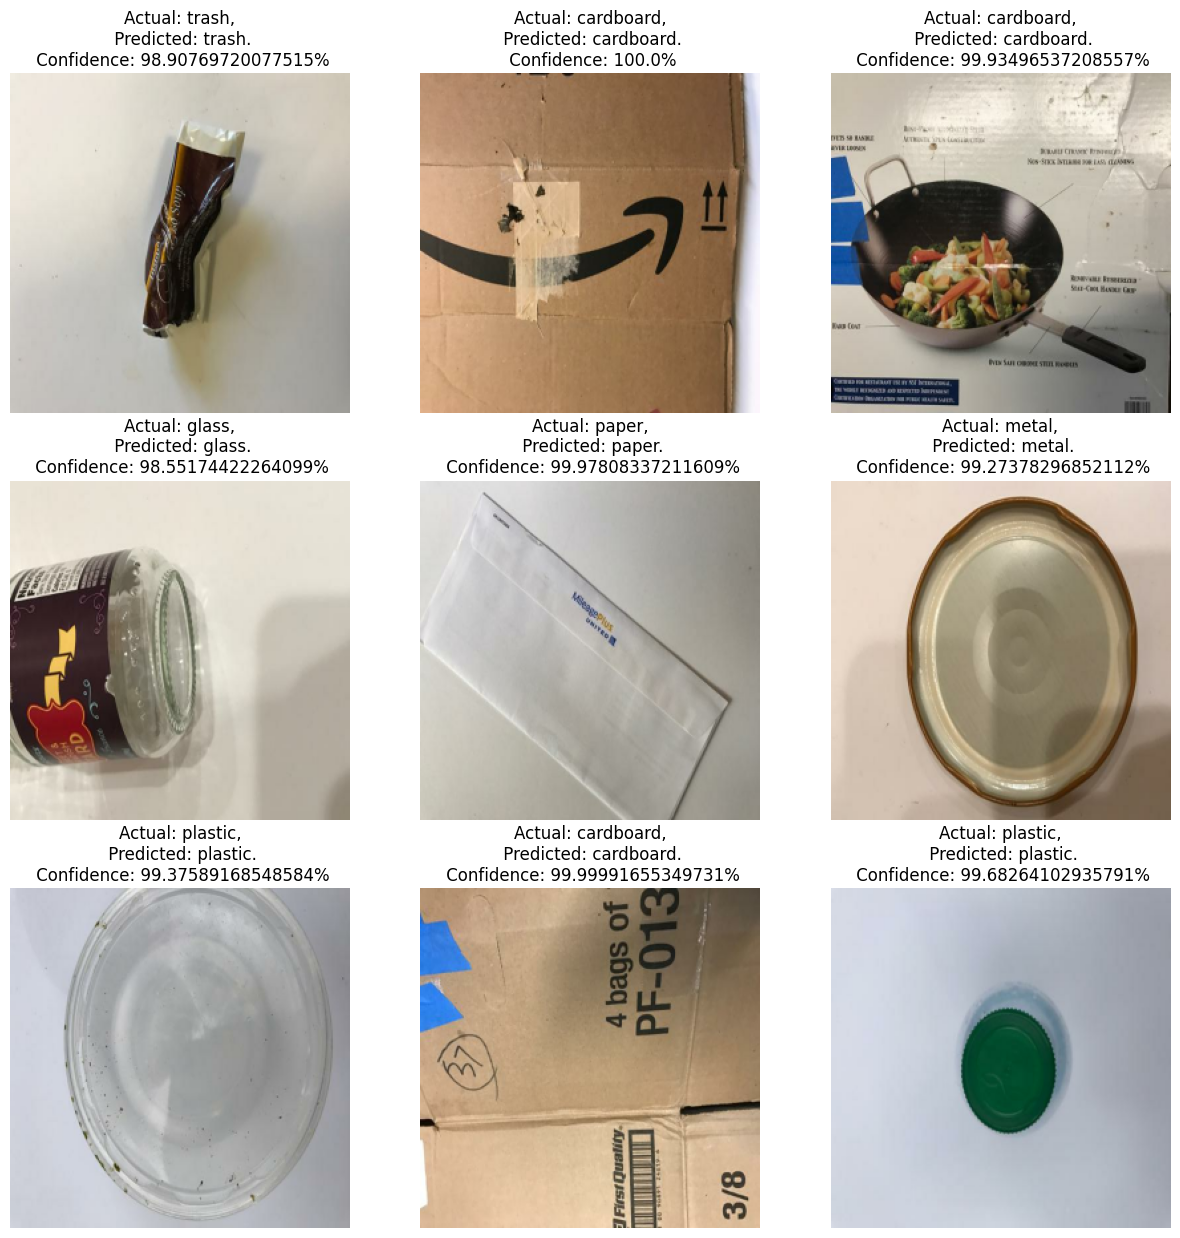

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
import os
os.makedirs("tf-lite")
model_version = max([int(i.split(".")[0]) for i in (os.listdir("tf-lite")+["0.tflite"])]) + 1

with open(
    f"tf-lite/{model_version}.tflite",
    'wb'
) as f:
    f.write(tflite_model)

In [ ]:
import shutil

# Compress the folder into a zip file
shutil.make_archive('tf-lite', 'zip', 'tf-lite')

'/content/tf-lite.zip'